In [98]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this assignment, you will solve a classic control problem - CartPole using policy gradient methods.

First, you will implement the "vanilla" policy gradient method, i.e., a method that repeatedly computes **unbiased** estimates $\hat{g}$ of $\nabla_{\theta} E[\sum_t r_t]$ and takes gradient ascent steps $\theta \rightarrow \theta + \epsilon \hat{g}$ so as to increase the total rewards collected in each episode. To make sure our code can solve multiple MDPs with different policy parameterizations, provided code follows an OOP manner and represents MDP and Policy as classes.

The following code constructs an instance of the MDP using OpenAI gym.

In [99]:
import gym
import tensorflow as tf
import numpy as np
#------------------------------
import matplotlib.pyplot as plt
#------------------------------
from policy_gradient import util
from policy_gradient.policy import CategoricalPolicy
from policy_gradient.baselines.linear_feature_baseline import LinearFeatureBaseline

np.random.seed(0)
tf.set_random_seed(0)

# CartPole-v0 is a MDP with finite state and action space. 
# In this environment, A pendulum is attached by an un-actuated joint to a cart, 
# and the goal is to prevent it from falling over. You can apply a force of +1 or -1 to the cart.
# A reward of +1 is provided for every timestep that the pendulum remains upright. 
# To visualize CartPole-v0, please see https://gym.openai.com/envs/CartPole-v0

env = gym.make('CartPole-v0')
#env.monitor.start('/tmp/cartpole-experiment-1')

[2016-10-17 10:18:51,729] Making new env: CartPole-v0


## Problem 1: construct a neural network to represent policy

Make sure you know how to construct neural network using tensorflow.

1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 1.

## Problem 2: compute the surrogate loss

If there are $N$ episodes in an iteration, then for $i$ th episode we define $R_t^i = \sum_{{t^′}=t}^T \gamma^{{t^′}-t}r(s_{t^′}, a_{t^′})$ as the accumulated discounted rewards from timestep $t$ to the end of that episode, where $\gamma$ is the discount rate.

The pseudocode for the REINFORCE algorithm is as below:

1. Initialize policy $\pi$ with parameter $\theta_1$.
2. For iteration $k = 1, 2, ...$:
    * Sample N episodes $\tau_1, \tau_2, ..., \tau_N$ under the current policy $\theta_k$, where $\tau_i =(s_i^t,a_i^t,R_i^t)_{t=0}^{T−1}$. Note that the last state is dropped since no action is taken after observing the last state.
    * Compute the empirical policy gradient using formula: $$\hat{g} = E_{\pi_\theta}[\nabla_{\theta} log\pi_\theta(a_t^i | s_t^i) R_t^i]$$
    * Take a gradient step: $\theta_{k+1} = \theta_k + \epsilon \hat{g}$.
    
    
Note that we can transform the policy gradient formula as

$$\hat{g} = \nabla_{\theta} \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) R_t^i)$$

and $L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) R_t^i)$ is called the surrogate loss. 

We can first construct the computation graph for $L(\theta)$, and then take its gradient as the empirical policy gradient.


1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 2.

In [100]:
sess = tf.Session()

# Construct a neural network to represent policy which maps observed state to action. 
in_dim = util.flatten_space(env.observation_space)
out_dim = util.flatten_space(env.action_space)
hidden_dim = 8

opt = tf.train.AdamOptimizer(learning_rate=0.01)
policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt, sess)

sess.run(tf.initialize_all_variables())

# Problem 3

Implement a function that computes the accumulated discounted rewards of each timestep _t_ from _t_ to the end of the episode.

For example:

```python
rewards = [1, 1, 1]
discount_rate = 0.99
util.discount_cumsum(rewards, discount_rate)
```

should return:

`array([ 2.9701,  1.99  ,  1.    ])`

1. Open **homework/policy_gradient/util.py**.
2. Implement the commented function.

# Problem 4

Use baseline to reduce the variance of our gradient estimate.

1. Fill in the function `process_paths` of class `PolicyOptimizer` below.

In [101]:
class PolicyOptimizer(object):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):

        self.policy = policy
        self.baseline = baseline
        self.env = env
        self.n_iter = n_iter
        self.n_episode = n_episode
        self.path_length = path_length
        self.discount_rate = discount_rate
        #----------------------------------
        self.stats = {} # A dictionary used to record loss , variance , return ....
        #----------------------------------

    def sample_path(self):
        obs = []
        actions = []
        rewards = []
        ob = self.env.reset()

        for _ in range(self.path_length):
            #--------------------
            #self.env.render()
            #---------------------
            a = self.policy.act(ob.reshape(1, -1))
            next_ob, r, done, _ = self.env.step(a)
            obs.append(ob)
            actions.append(a)
            rewards.append(r)
            ob = next_ob
            if done:
                break

        return dict(
            observations=np.array(obs),
            actions=np.array(actions),
            rewards=np.array(rewards),
        )

    def process_paths(self,paths):
        for p in paths:
                            
            if self.baseline != None:
                b = self.baseline.predict(p)
            else:
                b = 0
            # `p["rewards"]` is a matrix contains the rewards of each timestep in a sample path
            r = util.discount_cumsum(p["rewards"], self.discount_rate)
            """
            Problem 4:

            1. Variable `b` is the reward predicted by our baseline
            2. Use it to reduce variance and then assign the result to the variable `a`

            Sample solution should be only 1 line.
            """
            # YOUR CODE HERE >>>>>>>>>
            a = (r-b)
            # <<<<<<<<<<<<<<<<<<<<<<<<
            
            p["adv_var"] = np.var(a)
            p["returns"] = r
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize
    
        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])
        #-------------------------------------------------------------------
        adv_var = np.array([p["adv_var"] for p in paths])
        #-------------------------------------------------------------------
        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
            adv_var = adv_var
        )

    def train(self,return_list):
        self.stats['avg_adv_var_baseline'] = []
        #self.stats['avg_adv_var_nobase'] = []
        for i in range(1, self.n_iter + 1):
            paths = []
            for _ in range(self.n_episode):
                paths.append(self.sample_path())
            
            #----------------------------------------------------------------
            data = self.process_paths(paths)
            self.stats['avg_adv_var_baseline'].append(np.mean(data["adv_var"]))
            #self.stats['avg_adv_var_nobase'].append(np.mean(data["adv_var"])) 
            #----------------------------------------------------------------
            loss = self.policy.train(data["observations"], data["actions"], data["advantages"])
            avg_return = np.mean([sum(p["rewards"]) for p in paths])
            #-------------------------------------------------------------------------------------
            return_list.append(avg_return)
            #-------------------------------------------------------------------------------------
            print("Iteration {}: Average Return = {} ,Var_B = {}".format(i, avg_return,
                np.mean(data["adv_var"])))
            # CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
            if avg_return >= 195:
                print("Solve at {} iterations, which equals {} episodes.".format(i, i*100))
                break

            if self.baseline != None:
                self.baseline.fit(paths)
        

Iteration 1: Average Return = 25.44 ,Var_B = 47.1509761542
Iteration 2: Average Return = 28.53 ,Var_B = 45.8530490321
Iteration 3: Average Return = 31.93 ,Var_B = 42.3224804794
Iteration 4: Average Return = 28.97 ,Var_B = 36.2206476526
Iteration 5: Average Return = 32.99 ,Var_B = 27.651355086
Iteration 6: Average Return = 35.58 ,Var_B = 31.6471268862
Iteration 7: Average Return = 36.5 ,Var_B = 48.9792688507
Iteration 8: Average Return = 38.52 ,Var_B = 32.0712588709
Iteration 9: Average Return = 37.69 ,Var_B = 48.0459704406
Iteration 10: Average Return = 40.01 ,Var_B = 41.3751388452
Iteration 11: Average Return = 43.51 ,Var_B = 44.9528494541
Iteration 12: Average Return = 42.82 ,Var_B = 40.721662773
Iteration 13: Average Return = 46.35 ,Var_B = 44.3551316745
Iteration 14: Average Return = 44.99 ,Var_B = 38.2226437667
Iteration 15: Average Return = 47.34 ,Var_B = 48.3173365439
Iteration 16: Average Return = 46.66 ,Var_B = 30.8778415485
Iteration 17: Average Return = 48.53 ,Var_B = 37.836

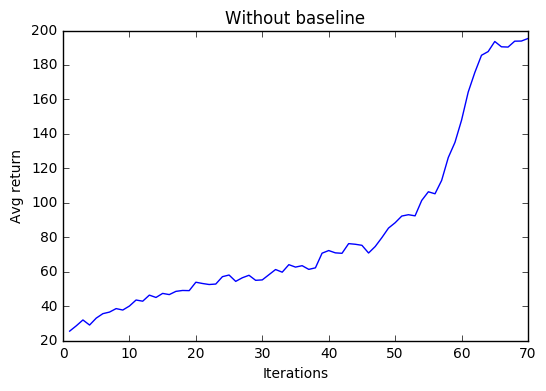

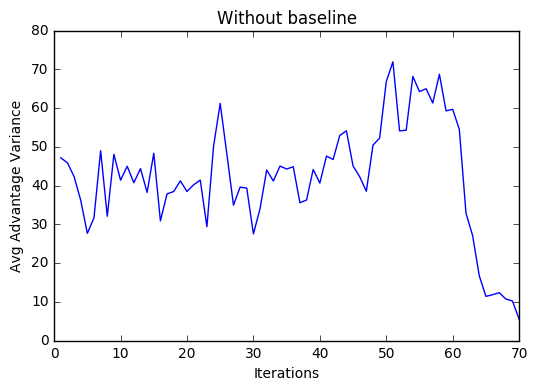

In [102]:
n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
baseline = LinearFeatureBaseline(env.spec)
#baseline = None
po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
return_list = []
po.train(return_list)
x = np.array(range(1,len(return_list)+1))
y = np.array(return_list)
plt.plot(x,y)
plt.xlabel("Iterations")
plt.ylabel("Avg return")
plt.title("Without baseline")
plt.show()

y1 = np.array(po.stats["avg_adv_var_baseline"])
#y2 = np.array(po.stats["avg_adv_var_nobase"])
plt.plot(x,y1)
#plt.plot(x,y2)
plt.xlabel("Iterations")
plt.ylabel("Avg Advantage Variance")
#plt.title("Without baseline")
plt.legend(["With baseline","No baseline"])
plt.show()


#env.monitor.close()

# Verify your solutions

if you solve the problems 1~4 correctly, your will solve CartPole with roughly ~ 80 iterations.

# Problem 5
Replacing line 

`baseline = LinearFeatureBaseline(env.spec)` 

with 

`baseline = None`

can remove the baseline.

Modify the code to compare the variance and performance before and after adding baseline.
Then, write a report about your findings. (with figures is better)

# Problem 6

In function process_paths of class `PolicyOptimizer`, why we need to normalize the advantages? i.e., what's the usage of this line:

`p["advantages"] = (a - a.mean()) / (a.std() + 1e-8)`

Include the answer in your report.